In [1]:
using Distributions
using Random
using StatsBase: ecdf
using StatsPlots
default(fmt=:png)

ECDF(A, x) = count(≤(x), A)/length(A)
safediv(x, y) = x == 0 ? zero(x/y) : x/y
x ⪅ y = x < y || x ≈ y

⪅ (generic function with 1 method)

In [2]:
function plot_ecdfpval(pvals;
        n = length(pvals), 
        labels = fill("", n),
        linestyles = fill(:auto, n),
        size = (400, 400),
        legend = :bottomright,
        kwargs...
    )
    _tick = Any[0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
    xtick = ytick = (float.(_tick), string.(_tick))
    xlim = ylim = (0.0015, 1.1)
    αs = range(0.002, 1, 1000)
    P = plot()
    for (pval, label, ls) in zip(pvals, labels, linestyles)
        _ecdf_pval = ecdf(pval)
        plot!(αs, α -> _ecdf_pval(α); label, ls, kwargs...)
    end
    plot!(αs, x->x; label="", ls=:dot, alpha=0.5, c=:black)
    plot!(αs, x->0.8x; label="", ls=:dot, alpha=0.3, c=:black)
    plot!(αs, x->1.2x; label="", ls=:dot, alpha=0.3, c=:black)
    plot!(; xscale=:log10, yscale=:log10, xtick, ytick, xlim, ylim)
    plot!(; xguide="α", yguide="probability of P-value ≤ α")
    plot!(; size, legend)
end

plot_ecdfpval (generic function with 1 method)

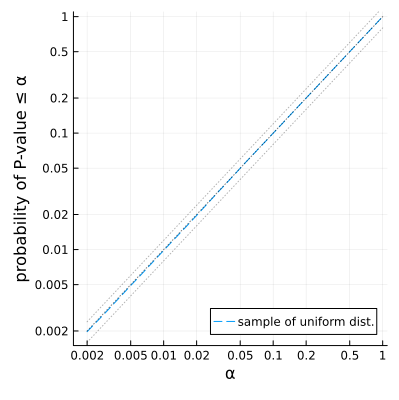

In [3]:
pval = rand(10^6)
plot_ecdfpval([pval]; labels=["sample of uniform dist."])

In [4]:
randpoissons(E) = @. rand(Poisson(E))

function randmultinomial((N, P))
    A = rand(Multinomial(N, vec(P)))
    reshape(A, size(P))
end

function randmultinomials((Ns, Ps))
    r = length(Ns)
    A = similar(Ps, Int)
    for i in 1:r
        rand!(Multinomial(Ns[i], @view(Ps[i,:])), @view(A[i,:]))
    end
    A
end

randmultinomials (generic function with 1 method)

In [5]:
expectval(A) = sum(A; dims=2) * sum(A; dims=1) / sum(A)

function pvalue_pearson_chisq_2x2(A)
    @assert size(A) == (2, 2)
    a, b, c, d = A'
    chi2 = (a+b+c+d)*safediv((a*d - b*c)^2, (a+b)*(c+d)*(a+c)*(b+d))
    ccdf(Chisq(1), chi2)
end

function pvalue_yates_chisq_2x2(A)
    @assert size(A) == (2, 2)
    a, b, c, d = A'
    N = a+b+c+d
    chi2 = N*safediv(max(0, abs(a*d - b*c) - N/2)^2, (a+b)*(c+d)*(a+c)*(b+d))
    ccdf(Chisq(1), chi2)
end

function pvalue_fisher_central_2x2(A)
    @assert size(A) == (2, 2)
    a, b, c, d = A'
    hg = Hypergeometric(a+b, c+d, a+c)
    min(1, 2cdf(hg, a), 2ccdf(hg, a-1))
end

function pvalue_fisher_minlike_2x2(A)
    @assert size(A) == (2, 2)
    a, b, c, d = A'
    hg = Hypergeometric(a+b, c+d, a+c)
    pa = pdf(hg, a)
    sum(pdf(hg, x) for x in support(hg) if pdf(hg, x) ⪅ pa)
end

function sim_2x2(randfunc, param; L=10^6)
    pval_fisher_central = zeros(L)
    pval_fisher_minlike = zeros(L)
    pval_pearson_chisq = zeros(L)
    pval_yates_chisq = zeros(L)
    Threads.@threads for i in 1:L
        A = randfunc(param)
        pval_fisher_central[i] = pvalue_fisher_central_2x2(A)
        pval_fisher_minlike[i] = pvalue_fisher_minlike_2x2(A)
        pval_pearson_chisq[i] = pvalue_pearson_chisq_2x2(A)
        pval_yates_chisq[i] = pvalue_yates_chisq_2x2(A)
    end
    pval_fisher_central, pval_fisher_minlike, pval_pearson_chisq, pval_yates_chisq
end

function plot_2x2(A; L=10^6)
    println("A =")
    show(stdout, MIME("text/plain"), A)
    println()
    println()
    
    @show pvalue_pearson_chisq_2x2(A)
    @show pvalue_yates_chisq_2x2(A)
    @show pvalue_fisher_central_2x2(A)
    @show pvalue_fisher_minlike_2x2(A)
    println()

    E = expectval(A)
    println("E = expectval(A) =")
    show(stdout, MIME("text/plain"), E)
    println()
    println()
    @show N = sum(A)
    @show Ns = sum(A; dims=2)
    println()
    
    randfuncs = (
        randpoissons, randpoissons,
        randmultinomial, randmultinomial,
        randmultinomials, randmultinomials,
    )
    params = (
        E, A,
        (N, E / N), (N, A / N),
        (Ns, E ./ Ns), (Ns, A ./ Ns),
    )
    names = (
        "Poissons under the null", "Poissons with expectation A", 
        "Multinomial under the null", "Multinomial with expectation A", 
        "Multinomials under the null", "Multinomials with expectation A", 
    )

    PP = []
    for (randfunc, param, name) in zip(randfuncs, params, names)
        (
            pval_fisher_central,
            pval_fisher_minlike,
            pval_pearson_chisq,
            pval_yates_chisq
        ) = sim_2x2(randfunc, param; L)
        println("-"^20, " $name")
        @show ECDF(pval_pearson_chisq, 0.05)
        @show ECDF(pval_yates_chisq, 0.05)
        @show ECDF(pval_fisher_central, 0.05)
        @show ECDF(pval_fisher_minlike, 0.05)
        println()
        @show ECDF(pval_pearson_chisq, 0.01)
        @show ECDF(pval_yates_chisq, 0.01)
        @show ECDF(pval_fisher_central, 0.01)
        @show ECDF(pval_fisher_minlike, 0.01)
        println()
        P = plot_ecdfpval(
            [pval_pearson_chisq, pval_yates_chisq, pval_fisher_central, pval_fisher_minlike];
            labels=["pearson chisq", "yates chisq", "fisher central", "fisher minlike"])
        title!("$name")
        push!(PP, P)
    end
    
    plot(PP...; size=(800, 1200), layout=(3, 2))
    plot!(titlefontsize=10)
end

plot_2x2 (generic function with 1 method)

A =
2×2 Matrix{Int64}:
 6  2
 2  7

pvalue_pearson_chisq_2x2(A) = 0.029549015619382227
pvalue_yates_chisq_2x2(A) = 0.09115659051595472
pvalue_fisher_central_2x2(A) = 0.08893459481694778
pvalue_fisher_minlike_2x2(A) = 0.056684491978609655

E = expectval(A) =
2×2 Matrix{Float64}:
 3.76471  4.23529
 4.23529  4.76471

N = sum(A) = 17
Ns = sum(A; dims = 2) = [8; 9;;]

-------------------- Poissons under the null
ECDF(pval_pearson_chisq, 0.05) = 0.05597
ECDF(pval_yates_chisq, 0.05) = 0.012833
ECDF(pval_fisher_central, 0.05) = 0.014836
ECDF(pval_fisher_minlike, 0.05) = 0.024394

ECDF(pval_pearson_chisq, 0.01) = 0.009658
ECDF(pval_yates_chisq, 0.01) = 0.001398
ECDF(pval_fisher_central, 0.01) = 0.001981
ECDF(pval_fisher_minlike, 0.01) = 0.003386

-------------------- Poissons with expectation A
ECDF(pval_pearson_chisq, 0.05) = 0.607163
ECDF(pval_yates_chisq, 0.05) = 0.376827
ECDF(pval_fisher_central, 0.05) = 0.391814
ECDF(pval_fisher_minlike, 0.05) = 0.465242

ECDF(pval_pearson_chisq, 0.01) = 0

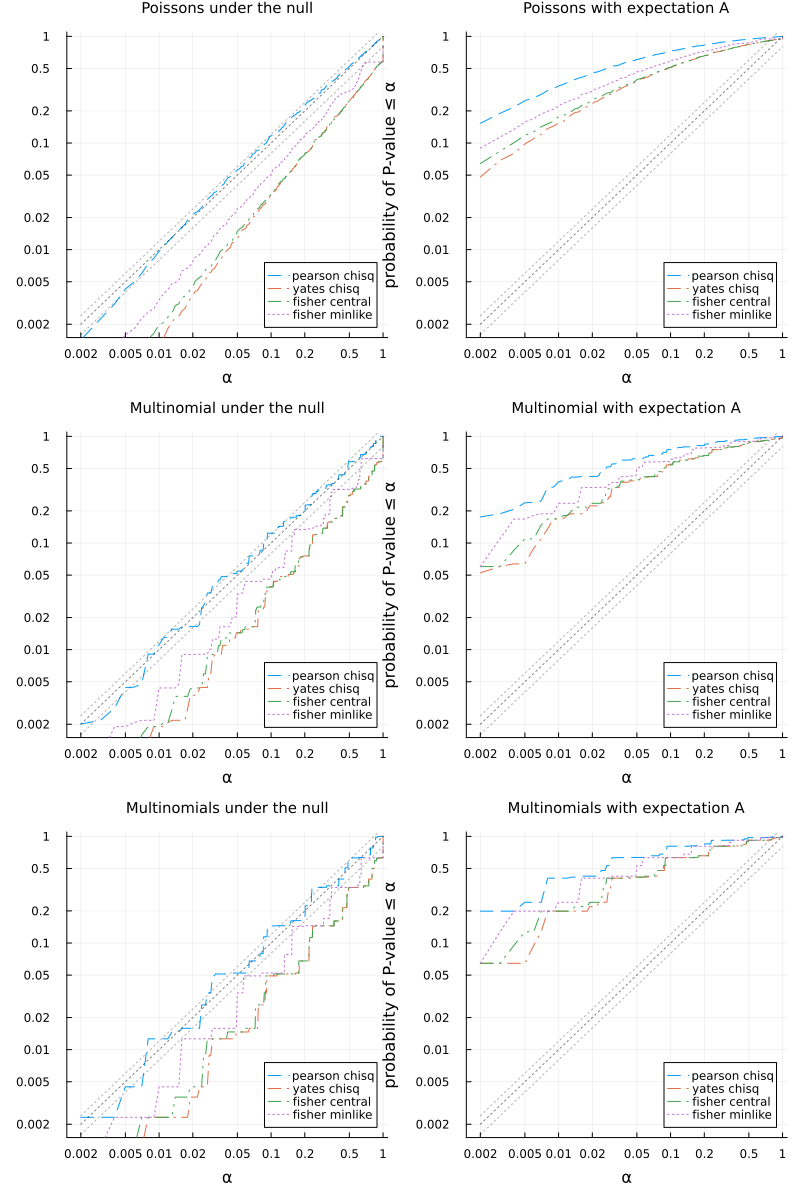

In [6]:
plot_2x2([6 2; 2 7])

A =
2×2 Matrix{Int64}:
 9  2
 2  7

pvalue_pearson_chisq_2x2(A) = 0.007693972527542988
pvalue_yates_chisq_2x2(A) = 0.026864471961340213
pvalue_fisher_central_2x2(A) = 0.02476780185758509
pvalue_fisher_minlike_2x2(A) = 0.021552750654917817

E = expectval(A) =
2×2 Matrix{Float64}:
 6.05  4.95
 4.95  4.05

N = sum(A) = 20
Ns = sum(A; dims = 2) = [11; 9;;]

-------------------- Poissons under the null
ECDF(pval_pearson_chisq, 0.05) = 0.055487
ECDF(pval_yates_chisq, 0.05) = 0.014615
ECDF(pval_fisher_central, 0.05) = 0.016617
ECDF(pval_fisher_minlike, 0.05) = 0.026329

ECDF(pval_pearson_chisq, 0.01) = 0.009668
ECDF(pval_yates_chisq, 0.01) = 0.001766
ECDF(pval_fisher_central, 0.01) = 0.002516
ECDF(pval_fisher_minlike, 0.01) = 0.004109

-------------------- Poissons with expectation A
ECDF(pval_pearson_chisq, 0.05) = 0.790687
ECDF(pval_yates_chisq, 0.05) = 0.604828
ECDF(pval_fisher_central, 0.05) = 0.616395
ECDF(pval_fisher_minlike, 0.05) = 0.682901

ECDF(pval_pearson_chisq, 0.01) = 0.555125
E

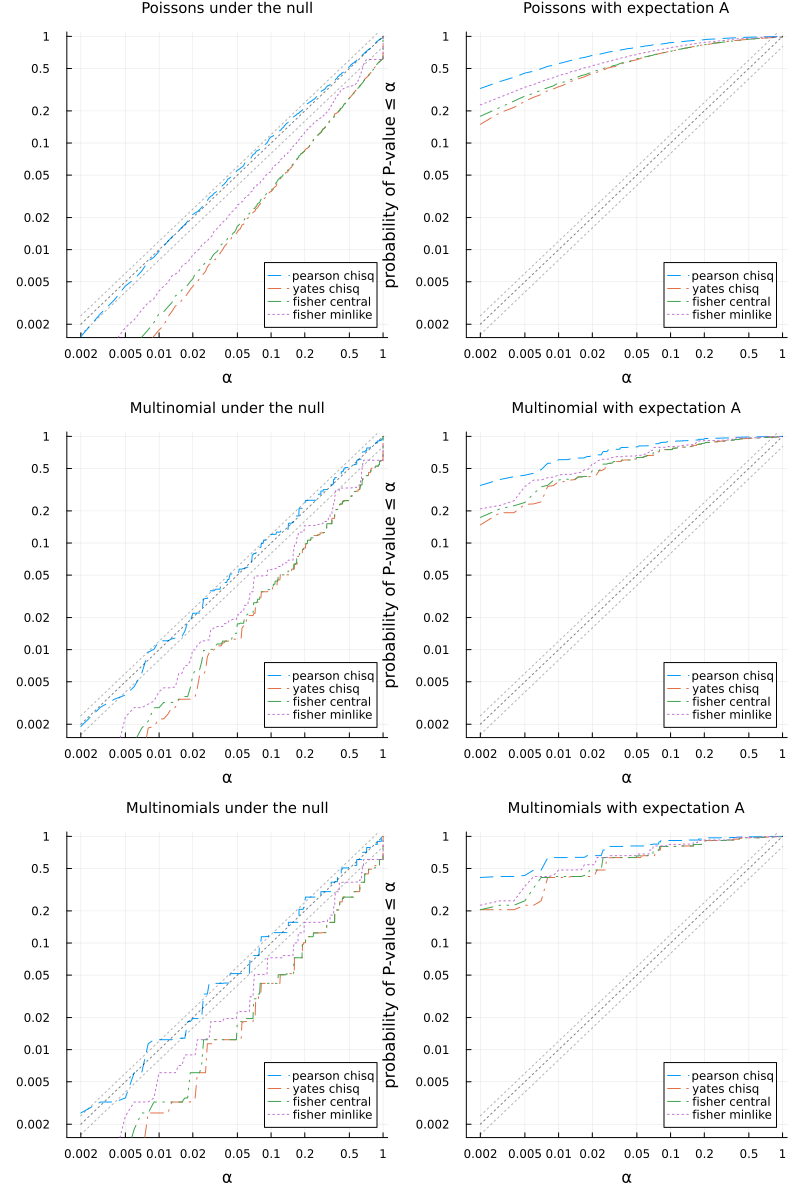

In [7]:
plot_2x2([9 2; 2 7])

In [8]:
function pearson_chisq_stat(A)
    E = expectval(A)
    sum(safediv((a - e)^2, e) for (a, e) in zip(A, E))
end

function pvalue_pearson_chisq(A)
    r, c = size(A)
    df = (r-1)*(c-1)
    chi2 = pearson_chisq_stat(A)
    ccdf(Chisq(df), chi2)
end

function sim_pearson_chisq_test(randfunc, param; L=10^6)
    pval = zeros(L)
    for i in 1:L
        A = randfunc(param)
        pval[i] = pvalue_pearson_chisq(A)
    end
    pval
end

function plot_pearson_chisq(A; L=10^6)
    println("A =")
    show(stdout, MIME("text/plain"), A)
    println()
    println()
    
    @show pvalue_pearson_chisq(A)
    println()

    E = expectval(A)
    println("E = expectval(A) =")
    show(stdout, MIME("text/plain"), E)
    println()
    println()
    @show N = sum(A)
    @show Ns = sum(A; dims=2)
    println()
    
    randfuncs = (
        randpoissons, randpoissons,
        randmultinomial, randmultinomial,
        randmultinomials, randmultinomials,
    )
    params = (
        E, A,
        (N, E / N), (N, A / N),
        (Ns, E ./ Ns), (Ns, A ./ Ns),
    )
    names = (
        "Poissons under the null", "Poissons with expectation A", 
        "Multinomial under the null", "Multinomial with expectation A", 
        "Multinomials under the null", "Multinomials with expectation A", 
    )

    PP = []
    for (randfunc, param, name) in zip(randfuncs, params, names)
        pval = sim_pearson_chisq_test(randfunc, param; L)
        println("-"^20, " $name")
        @show ECDF(pval, 0.05)
        @show ECDF(pval, 0.01)
        P = plot_ecdfpval([pval]; linestyles=[:solid])
        title!("$name")
        push!(PP, P)
    end
    println()
    
    plot(PP...; size=(800, 1200), layout=(3, 2))
    plot!(titlefontsize=10)
end

plot_pearson_chisq (generic function with 1 method)

A =
2×3 Matrix{Int64}:
  7  4  23
 10  8   8

pvalue_pearson_chisq(A) = 0.016573344201902547

E = expectval(A) =
2×3 Matrix{Float64}:
 9.63333  6.8  17.5667
 7.36667  5.2  13.4333

N = sum(A) = 60
Ns = sum(A; dims = 2) = [34; 26;;]

-------------------- Poissons under the null
ECDF(pval, 0.05) = 0.05056
ECDF(pval, 0.01) = 0.009057
-------------------- Poissons with expectation A
ECDF(pval, 0.05) = 0.740802
ECDF(pval, 0.01) = 0.504474
-------------------- Multinomial under the null
ECDF(pval, 0.05) = 0.050469
ECDF(pval, 0.01) = 0.00899
-------------------- Multinomial with expectation A
ECDF(pval, 0.05) = 0.744954
ECDF(pval, 0.01) = 0.509074
-------------------- Multinomials under the null
ECDF(pval, 0.05) = 0.050789
ECDF(pval, 0.01) = 0.008965
-------------------- Multinomials with expectation A
ECDF(pval, 0.05) = 0.755164
ECDF(pval, 0.01) = 0.51715



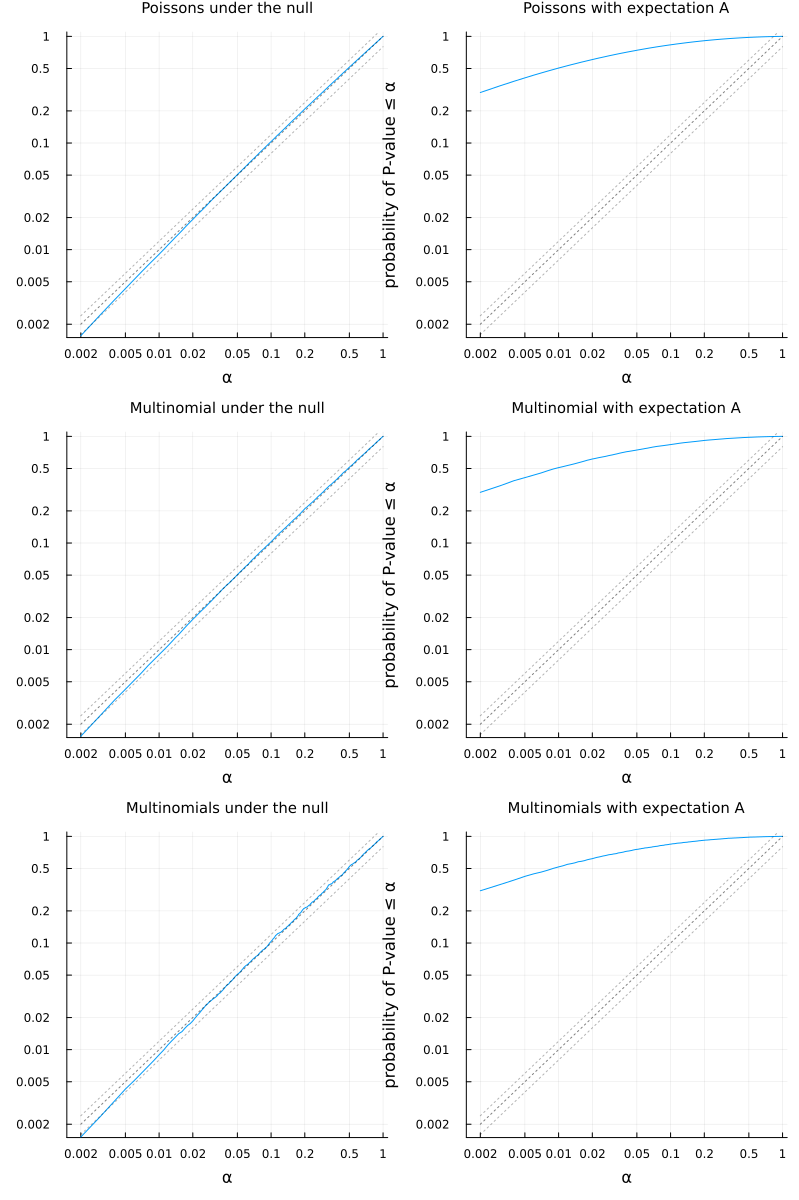

In [9]:
A = [
     7  4 23
    10  8  8
]
plot_pearson_chisq(A)

A =
2×3 Matrix{Int64}:
  7  2  23
 10  4   8

pvalue_pearson_chisq(A) = 0.032765677544625275

E = expectval(A) =
2×3 Matrix{Float64}:
 10.0741   3.55556  18.3704
  6.92593  2.44444  12.6296

N = sum(A) = 54
Ns = sum(A; dims = 2) = [32; 22;;]

-------------------- Poissons under the null
ECDF(pval, 0.05) = 0.046699
ECDF(pval, 0.01) = 0.007776
-------------------- Poissons with expectation A
ECDF(pval, 0.05) = 0.656257
ECDF(pval, 0.01) = 0.406895
-------------------- Multinomial under the null
ECDF(pval, 0.05) = 0.046941
ECDF(pval, 0.01) = 0.007806
-------------------- Multinomial with expectation A
ECDF(pval, 0.05) = 0.662855
ECDF(pval, 0.01) = 0.406254
-------------------- Multinomials under the null
ECDF(pval, 0.05) = 0.046963
ECDF(pval, 0.01) = 0.007482
-------------------- Multinomials with expectation A
ECDF(pval, 0.05) = 0.668596
ECDF(pval, 0.01) = 0.420467



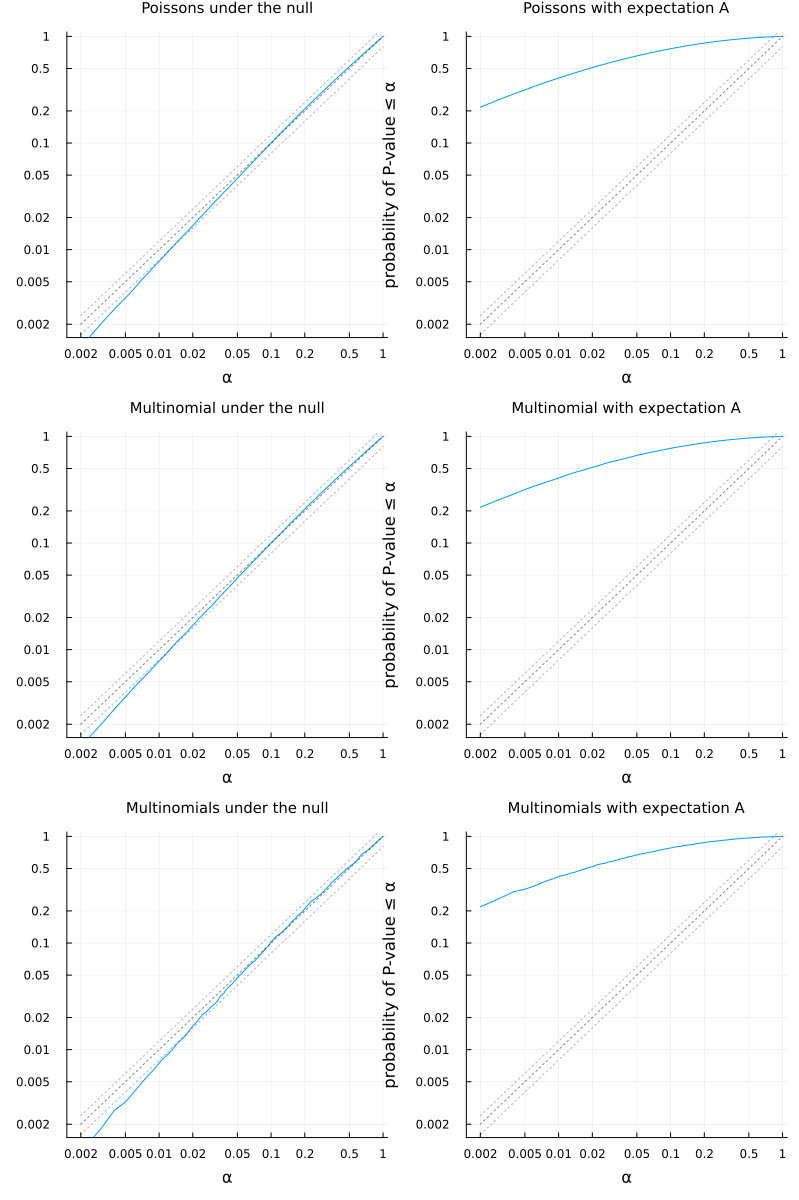

In [10]:
A = [
     7  2 23
    10  4  8
]
plot_pearson_chisq(A)

A =
2×3 Matrix{Int64}:
 7  4  23
 5  4   4

pvalue_pearson_chisq(A) = 0.06725720099757504

E = expectval(A) =
2×3 Matrix{Float64}:
 8.68085  5.78723  19.5319
 3.31915  2.21277   7.46809

N = sum(A) = 47
Ns = sum(A; dims = 2) = [34; 13;;]

-------------------- Poissons under the null
ECDF(pval, 0.05) = 0.047047
ECDF(pval, 0.01) = 0.008817
-------------------- Poissons with expectation A
ECDF(pval, 0.05) = 0.56482
ECDF(pval, 0.01) = 0.322994
-------------------- Multinomial under the null
ECDF(pval, 0.05) = 0.047432
ECDF(pval, 0.01) = 0.009044
-------------------- Multinomial with expectation A
ECDF(pval, 0.05) = 0.568408
ECDF(pval, 0.01) = 0.323115
-------------------- Multinomials under the null
ECDF(pval, 0.05) = 0.04696
ECDF(pval, 0.01) = 0.008508
-------------------- Multinomials with expectation A
ECDF(pval, 0.05) = 0.578732
ECDF(pval, 0.01) = 0.322785



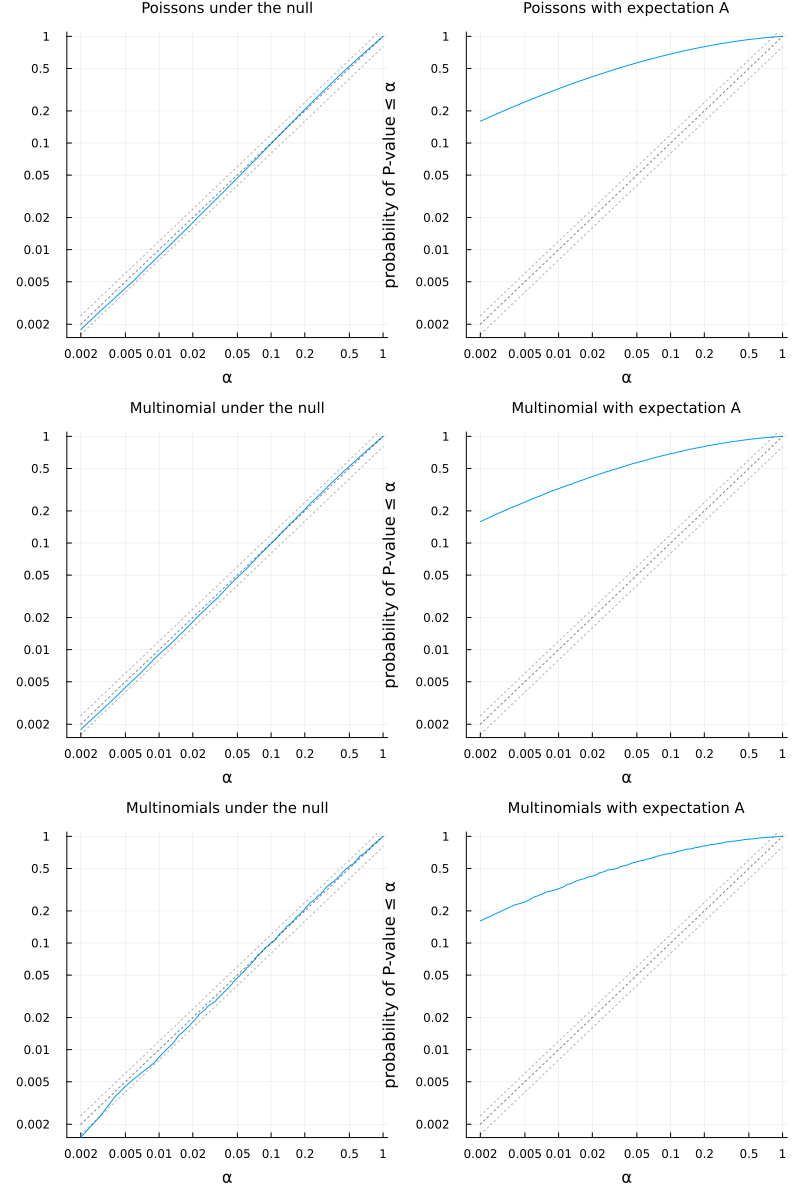

In [11]:
A = [
     7  4 23
     5  4  4
]
plot_pearson_chisq(A)